# Embed / visualize question / answers

In [1]:
%load_ext autoreload
%autoreload 2


In [12]:
from openai import OpenAI
import os 
import sys 
from pprint import pprint
from IPython.display import display, Markdown, Latex

sys.path.append('../')

from utils.pdf import read_pdf
from pydantic import BaseModel, Field
from typing import List
import json

from pipeline.entity_extraction import ENTITY_EXTRACTION_SYSTEM_PROMPT, EntityExtractionModel
from pipeline.question_answer import QUESTION_EXTRACTION_SYSTEM_PROMPT, QuestionAnswerModel
from pipeline.helpers import get_json_response, get_messages_response, split_text, list_of_dicts_to_dict_of_lists, upload_to_hf
from datasets import Dataset, load_dataset
import requests
from dotenv import find_dotenv, load_dotenv

load_dotenv()

True

## use nomic-embed-text embeddings from ollama

In [4]:
OLLAMA_URL = "http://localhost:11434/api/embeddings"
EMBEDDING_MODEL = "nomic-embed-text"

In [7]:
resp = requests.post(OLLAMA_URL, 
              json={"model": EMBEDDING_MODEL, "prompt": "hello world"}).json()

## Import dataset from HF

In [11]:
len(resp.json().get('embedding'))

768

In [16]:
dataset = load_dataset(
                    "owenren/532_finetune_qa_datasets", 
                    token=os.getenv('HUGGINGFACE_API_KEY'),
                    name="test_dataset2_2024OCT20"
                    )


Generating train split: 100%|██████████| 96/96 [00:00<00:00, 9022.84 examples/s]


In [33]:
qa_with_embeddings = []
for row in dataset['train']:
    question_embedding = requests.post(
                                        OLLAMA_URL, 
                                        json={
                                            "model": EMBEDDING_MODEL, 
                                            "prompt": row['question']
                                            }
                                        ).json().get('embedding')

    answer_embedding = requests.post(
                                        OLLAMA_URL, 
                                        json={
                                            "model": EMBEDDING_MODEL, 
                                            "prompt": row['answer']
                                            }
                                        ).json().get('embedding')


    qa_with_embeddings.append({
        'question': row['question'],
        'answer': row['answer'],
        'source': row['source'],
        'question_embedding': question_embedding,
        'answer_embedding': answer_embedding
        })


In [35]:
len(qa_with_embeddings)

96

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
similarity_matrix = cosine_similarity([x['question_embedding'] for x in qa_with_embeddings])

In [44]:
similarity_matrix.shape

(96, 96)

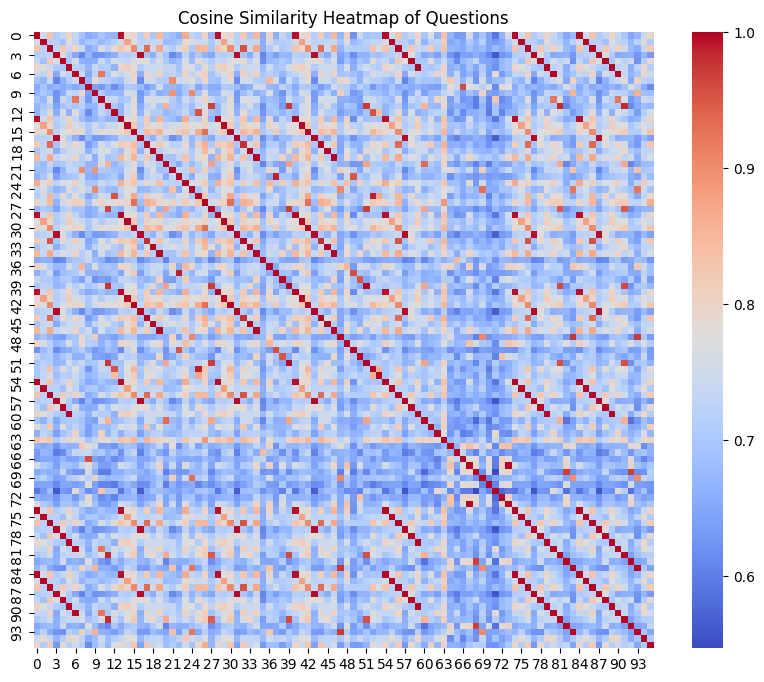

In [47]:

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity Heatmap of Questions")
plt.show()

In [45]:
threshold = 0.9

# 3. Find all pairs of queries that have a cosine similarity above the threshold
# We will skip the diagonal (self-similarity) and only check upper triangle (i < j)
duplicate_pairs = []
n_queries = similarity_matrix.shape[0]
for i in range(n_queries):
    for j in range(i + 1, n_queries):  # Avoid duplicates and self-comparison
        if similarity_matrix[i][j] > threshold:
            duplicate_pairs.append((i, j, similarity_matrix[i][j]))

# 4. Output the results
if duplicate_pairs:
    print(f"Found {len(duplicate_pairs)} duplicated query pairs:")
    for i, j, similarity in duplicate_pairs:
        print(f"Query {i}: {qa_with_embeddings[i].get('question')}")
        print(f"Query {j}: {qa_with_embeddings[j].get('question')}")
        print(f"Similarity: {similarity:.2f}\n")
else:
    print("No duplicates found based on the given threshold.")

Found 154 duplicated query pairs:
Query 0: What is the purpose of using a convolutional approach to efficiently learn a codebook of context-rich visual parts in the framework described in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Query 13: What is the purpose of using a convolutional approach to learn a codebook of context-rich visual parts in the framework described in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Similarity: 1.00

Query 0: What is the purpose of using a convolutional approach to efficiently learn a codebook of context-rich visual parts in the framework described in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Query 28: What is the purpose of using a convolutional approach to learn a codebook of context-rich visual parts in the framework described in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Similarity: 1.00

Query 0: What is the purpose of using a convolutional approa

Get outliers

In [48]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

mean_embedding = np.mean([x['question_embedding'] for x in qa_with_embeddings], axis=0)

# Compute the Euclidean distance of each embedding to the mean embedding
distances = euclidean_distances([x['question_embedding'] for x in qa_with_embeddings], [mean_embedding])

# Sort by distance to find outliers
outlier_indices = np.argsort(distances[:, 0])[-5:]  # Get top 5 outliers
print(f"Outlier question indices: {outlier_indices}")
for i in outlier_indices:
    print(f"Outlier Question {i}: {qa_with_embeddings[i].get('question')}")

Outlier question indices: [68 65 66 71 70]
Outlier Question 68: What is the difference between the original VQVAE and the VQ_GAN framework, as explained in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Outlier Question 65: How does the straight-through gradient estimator work, and what are some of its advantages and disadvantages, according to the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Outlier Question 66: What is the role of the stop-gradient operation in the VQ_GAN framework, as explained in the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Outlier Question 71: How does the autoregressive structure of the transformer affect the computation of the negative log-likelihood, and what are some of its implications, according to the paper 'Taming Transformers for High-Resolution Image Synthesis'?
Outlier Question 70: What is the purpose of using a conditional normalizing flow in the VQ_GAN framework, as explained in the pap

In [53]:
import pandas as pd 
df = pd.DataFrame(qa_with_embeddings)